In [100]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [4]:
rx = pd.read_csv("./data/pharmacy_tx.csv")

In [5]:
rx[["drug_type","drug_name"]] = rx['drug'].str.split(" ",expand=True)

### Acceptance/Rejection

In [6]:
## Make the train test split for all transactions (when looking to predict acceptance/rejection)
rx_train, rx_test = train_test_split(rx.copy(), 
                                            shuffle=True,
                                            random_state=614,
                                            test_size=.2, 
                                            stratify=rx.rejected)

Drop columns that we do not want to include in model:

In [9]:
X = rx_train.drop(["tx_date", "drug", "rejected", "patient_pay", "bin", "pcn", "group", "pharmacy"], axis = 1)
y = rx_train["rejected"]

In [10]:
X.head()

,diagnosis,drug_type,drug_name
2473692,M06.85,branded,nephelilin
12640130,G51.87,branded,prazinib
7240681,W50.87,branded,lalol
10012311,U06.52,generic,ratin
6397300,I68.27,branded,prazinib


In [11]:
X["diagnosis"] = X["diagnosis"].astype("category")
X["drug_type"] = X["drug_type"].astype("category")
X["drug_name"] = X["drug_name"].astype("category")

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, random_state=1994, test_size=0.2)

In [13]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

False    0.921923
True     0.078077
Name: rejected, dtype: float64
False    0.921639
True     0.078361
Name: rejected, dtype: float64


In [102]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
clf = xgboost.XGBClassifier(tree_method="hist", eval_metric="auc", enable_categorical=True, max_cat_to_onehot=1)

# X is the dataframe we created in previous snippet
clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)])

# Must use JSON/UBJSON for serialization, otherwise the information is lost.
clf.save_model("categorical-model.json")

[0]	validation_0-auc:0.89045	validation_1-auc:0.89100
[1]	validation_0-auc:0.89047	validation_1-auc:0.89102
[2]	validation_0-auc:0.89048	validation_1-auc:0.89103
[3]	validation_0-auc:0.89048	validation_1-auc:0.89104
[4]	validation_0-auc:0.89048	validation_1-auc:0.89105
[5]	validation_0-auc:0.89049	validation_1-auc:0.89105
[6]	validation_0-auc:0.89049	validation_1-auc:0.89105
[7]	validation_0-auc:0.89052	validation_1-auc:0.89109
[8]	validation_0-auc:0.89052	validation_1-auc:0.89109
[9]	validation_0-auc:0.89052	validation_1-auc:0.89109
[10]	validation_0-auc:0.89053	validation_1-auc:0.89110
[11]	validation_0-auc:0.89052	validation_1-auc:0.89110
[12]	validation_0-auc:0.89052	validation_1-auc:0.89110
[13]	validation_0-auc:0.89051	validation_1-auc:0.89110
[14]	validation_0-auc:0.89051	validation_1-auc:0.89110
[15]	validation_0-auc:0.89051	validation_1-auc:0.89110
[16]	validation_0-auc:0.89051	validation_1-auc:0.89111
[17]	validation_0-auc:0.89051	validation_1-auc:0.89111
[18]	validation_0-au

In [103]:
y_score = clf.predict_proba(X_test)[:, 1]  # proba of positive samples
auc = roc_auc_score(y_test, y_score)
print("AUC of using builtin categorical data support:", auc)

AUC of using builtin categorical data support: 0.8904666067087799


In [17]:
#Get feature importances
print(clf.feature_names_in_)
print(clf.feature_importances_)

['diagnosis' 'drug_type' 'drug_name']
[0.0022659  0.24890755 0.7488265 ]


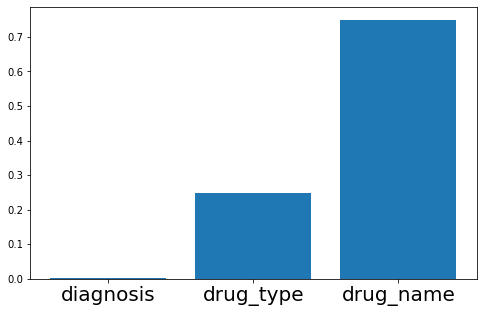

In [125]:
# plot feature importance
plt.figure(figsize=(8,5))
plt.bar(clf.feature_names_in_, clf.feature_importances_)
plt.xticks(fontsize=20)
plt.show()

In [104]:
y_pred = clf.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

[[2051230       6]
 [ 174400       3]]
0.9216377858224087


In [105]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96   2051236
        True       0.33      0.00      0.00    174403

    accuracy                           0.92   2225639
   macro avg       0.63      0.50      0.48   2225639
weighted avg       0.88      0.92      0.88   2225639



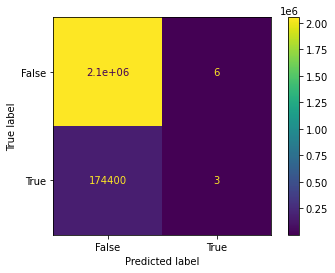

In [106]:
# confusion matrix at default 0.5 threshold
disp = metrics.ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=clf.classes_)
disp.plot()
plt.show()

In [39]:
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score

In [40]:
# from https://amirhessam88.github.io/finding-thresholds/
def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.show()

#*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
# Function: Plotting Confusion Matrix
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

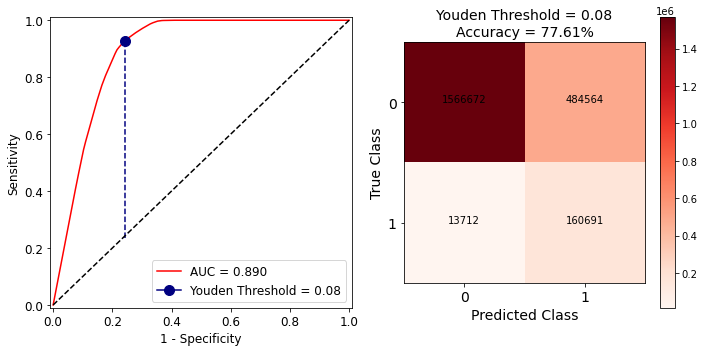

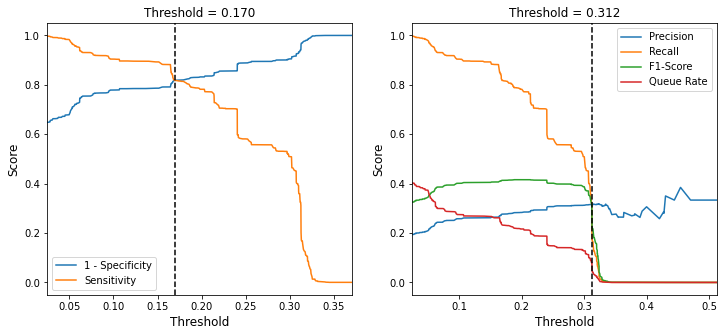

In [41]:
_threshold_finder(model = clf, X = X_test, y_true = y_test)

In [86]:
import ipywidgets as widgets
from ipywidgets import interact #interactive dashboard
from sklearn.metrics import ConfusionMatrixDisplay

In [88]:
def make_cnf_matrix(threshold):
    y_pred_proba = clf.predict_proba(X_test)[:,-1]
    y_pred = y_pred_proba > threshold
    conf_matrix = confusion_matrix(y_test, y_pred)
    tn,fp,fn,tp = conf_matrix.ravel()
    print(f'Precision: {tp/(tp+fp)}')
    print(f'Specificity: {tn/(tn+fp)}')
    print(f'Recall: {tp/(tp+fn)}')
    ConfusionMatrixDisplay.from_predictions \
    (y_test,y_pred,colorbar=False)


#The user will put the value in here. 
thresh_widget = widgets.FloatSlider(min=0, \
max=1 , value=0.5 , step=0.01)

#This is where the input will be set in to the passed to the function
interact(make_cnf_matrix, threshold=thresh_widget);


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

In [67]:
# identify false negatives, do they have anything in common we can use to improve the model? TBD

fn = np.where(y_test>y_pred)
X_test.iloc[fn]

,diagnosis,drug_type,drug_name
2335552,I68.27,branded,hidizuzunib
2043703,I68.27,branded,mule
5077654,X75.30,branded,nephelilin
5189669,I68.27,branded,mule
9874456,I68.27,branded,mule
...,...,...,...
3514512,I68.27,branded,mule
1051621,W50.87,branded,pucomalol
5693044,I38.43,generic,sorine
6519361,I68.27,branded,mule


### Patient pay

In [69]:
rx_accepted = rx[rx["rejected"] == False]

In [70]:
## Make the train test split for accepted transactions only
acc_train, acc_test = train_test_split(rx_accepted.copy(), 
                                            shuffle=True,
                                            random_state=614,
                                            test_size=.2)

In [71]:
acc_train.head()

,tx_date,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,drug_type,drug_name
10120050,2022-09-29,Pharmacy #26,G99.93,branded hozirol,664344,T17LNK,Z01MLD4I,False,17.44,branded,hozirol
687578,2022-01-21,Pharmacy #31,G51.87,branded prazinib,725700,NaN,DYGBI610ZY,False,11.22,branded,prazinib
9300050,2022-09-09,Pharmacy #28,Q85.91,branded plazamiglutic,322463,T52GV,EVD4X5,False,8.21,branded,plazamiglutic
631063,2022-01-20,Pharmacy #4,H36.57,branded antimab,571569,KB38N,6BYJBW,False,23.26,branded,antimab
8642802,2022-08-23,Pharmacy #54,K32.86,branded tanoclolol,664344,BIZF,QK6BI1N61,False,11.62,branded,tanoclolol


In [74]:
Xacc = acc_train.drop(["tx_date", "drug", "patient_pay", "pharmacy", "rejected"], axis = 1)
yacc = acc_train["patient_pay"]

In [75]:
Xacc.head()

,diagnosis,bin,pcn,group,drug_type,drug_name
10120050,G99.93,664344,T17LNK,Z01MLD4I,branded,hozirol
687578,G51.87,725700,NaN,DYGBI610ZY,branded,prazinib
9300050,Q85.91,322463,T52GV,EVD4X5,branded,plazamiglutic
631063,H36.57,571569,KB38N,6BYJBW,branded,antimab
8642802,K32.86,664344,BIZF,QK6BI1N61,branded,tanoclolol


In [76]:
Xacc["diagnosis"] = Xacc["diagnosis"].astype("category")
Xacc["drug_type"] = Xacc["drug_type"].astype("category")
Xacc["drug_name"] = Xacc["drug_name"].astype("category")
Xacc["bin"] = Xacc["bin"].astype("category")
Xacc["pcn"] = Xacc["pcn"].astype("category")
Xacc["group"] = Xacc["group"].astype("category")

In [77]:
Xacc_train, Xacc_test, yacc_train, yacc_test = train_test_split(
                                    Xacc, yacc, random_state=22, test_size=0.2)

In [78]:
# Supported tree methods are `gpu_hist`, `approx`, and `hist`.
reg_acc = xgboost.XGBRegressor(tree_method="hist", enable_categorical=True, max_cat_to_onehot=1)
# X is the dataframe we created in previous snippet
reg_acc.fit(Xacc_train, yacc_train, eval_set=[(Xacc_test, yacc_test), (Xacc_train, yacc_train)])
# Must use JSON/UBJSON for serialization, otherwise the information is lost.
reg_acc.save_model("regression-model_pay.json")

[0]	validation_0-rmse:34.15527	validation_1-rmse:34.11041
[1]	validation_0-rmse:24.66910	validation_1-rmse:24.63213
[2]	validation_0-rmse:18.16734	validation_1-rmse:18.13693
[3]	validation_0-rmse:13.78243	validation_1-rmse:13.76247
[4]	validation_0-rmse:10.90279	validation_1-rmse:10.89037
[5]	validation_0-rmse:8.96452	validation_1-rmse:8.95534
[6]	validation_0-rmse:7.54340	validation_1-rmse:7.54142
[7]	validation_0-rmse:6.73176	validation_1-rmse:6.73096
[8]	validation_0-rmse:6.16681	validation_1-rmse:6.17132
[9]	validation_0-rmse:5.74314	validation_1-rmse:5.74300
[10]	validation_0-rmse:5.48164	validation_1-rmse:5.48349
[11]	validation_0-rmse:5.23838	validation_1-rmse:5.24157
[12]	validation_0-rmse:5.11101	validation_1-rmse:5.11418
[13]	validation_0-rmse:4.85790	validation_1-rmse:4.86153
[14]	validation_0-rmse:4.71080	validation_1-rmse:4.71258
[15]	validation_0-rmse:4.56564	validation_1-rmse:4.56676
[16]	validation_0-rmse:4.42590	validation_1-rmse:4.42346
[17]	validation_0-rmse:4.37400	

In [79]:
# Get feature importances
print(reg_acc.feature_names_in_)
print(reg_acc.feature_importances_)

['diagnosis' 'bin' 'pcn' 'group' 'drug_type' 'drug_name']
[0.01 0.02 0.04 0.23 0.02 0.67]


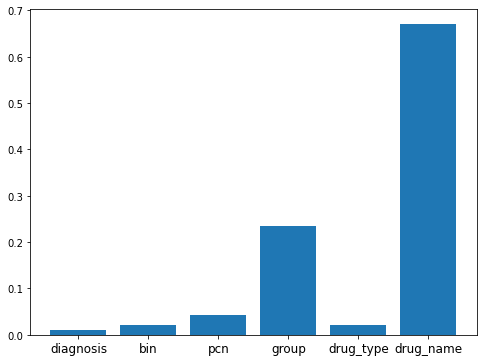

In [128]:
# plot feature importance
plt.figure(figsize=(8,6))
plt.bar(reg_acc.feature_names_in_, reg_acc.feature_importances_)
plt.xticks(fontsize=12)
plt.show()

In [95]:
from sklearn.metrics import mean_absolute_error

In [114]:
acc_test["diagnosis"] = acc_test["diagnosis"].astype("category")
acc_test["drug_type"] = acc_test["drug_type"].astype("category")
acc_test["drug_name"] = acc_test["drug_name"].astype("category")
acc_test["bin"] = acc_test["bin"].astype("category")
acc_test["pcn"] = acc_test["pcn"].astype("category")
acc_test["group"] = acc_test["group"].astype("category")

In [123]:
y_pred_baseline = acc_test['patient_pay'].mean()*np.ones(len(acc_test))

y_pred = reg_acc.predict(acc_test[['diagnosis', 'bin', 'pcn', 'group', 'drug_type', 'drug_name']])

#Mean absolute error
mae_baseline = mean_absolute_error(acc_test['patient_pay'], y_pred_baseline)
mae_reg = mean_absolute_error(acc_test['patient_pay'],y_pred)

print("Mean patient pay", round(acc_test['patient_pay'].mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))
print("Model MAE:", round(mae_reg, 2))

Mean patient pay 26.1
Baseline MAE: 21.8
Model MAE: 1.17
